# AIPI 590 - XAI | Assignment #3
Interpretable Machine Learning for Customer Churn Prediction

## Rishabh Shah

## Overview
In this notebook, we analyze a dataset from a telecommunications company that is interested in understanding customer churn. We will build multiple interpretable models (Linear Regression, Logistic Regression, and GAM) to predict customer churn and compare their performance.

---

## 1. Importing Libraries and Loading Data
We start by importing necessary libraries and loading the dataset.

In [1]:
# !pip install pandas numpy matplotlib seaborn scikit-learn pygam imblearn shap lime

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from statsmodels.gam.api import GLMGam, BSplines

# Load dataset
# data = pd.read_csv('telco_customer_churn.csv')
data = pd.read_csv('Telco-Customer-Churn.csv')


# Display first few rows of the data
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Exploratory Data Analysis (EDA)

### 2.1 Data Cleaning and Preprocessing
We need to check for missing values, data types, and clean any anomalies in the data.

In [3]:
# Checking for missing values and data types
data.info()

# Summary statistics
data.describe()

# Replace missing values or remove columns if necessary
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### 2.2 Understanding Target Variable (Churn)
We need to understand the distribution of the target variable (Churn) to check for imbalance in the dataset.

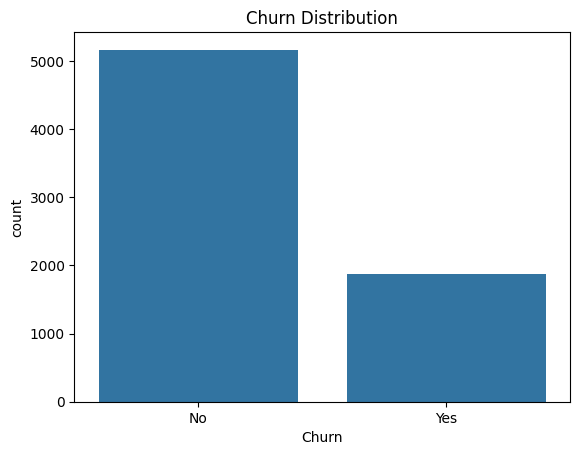

In [4]:
# Plotting churn distribution
sns.countplot(x='Churn', data=data)
plt.title('Churn Distribution')
plt.show()

# Converting Churn column to binary values (Yes = 1, No = 0)
data['Churn'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)


### 2.3 Feature Relationships
We will analyze relationships between customer features and churn. For numeric features, correlation analysis will help, while categorical features will use group comparisons.

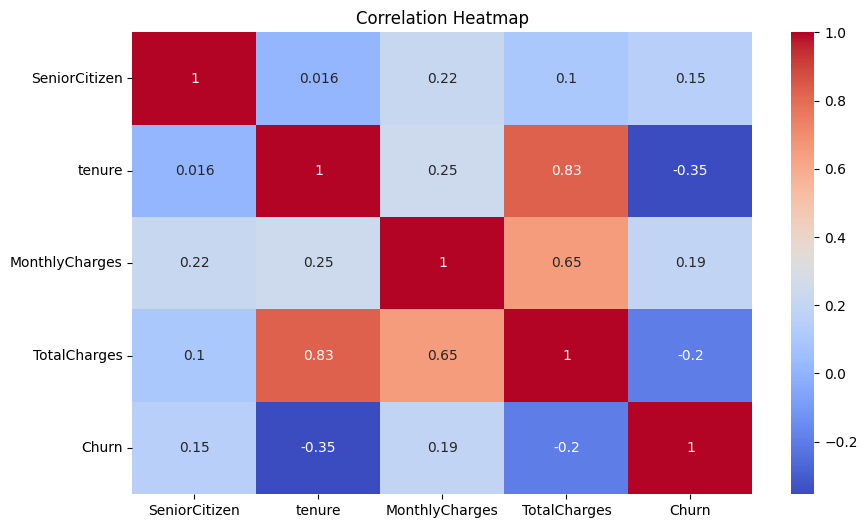

In [5]:
# Select only numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Correlation Heatmap for numerical features
plt.figure(figsize=(10,6))
sns.heatmap(data[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


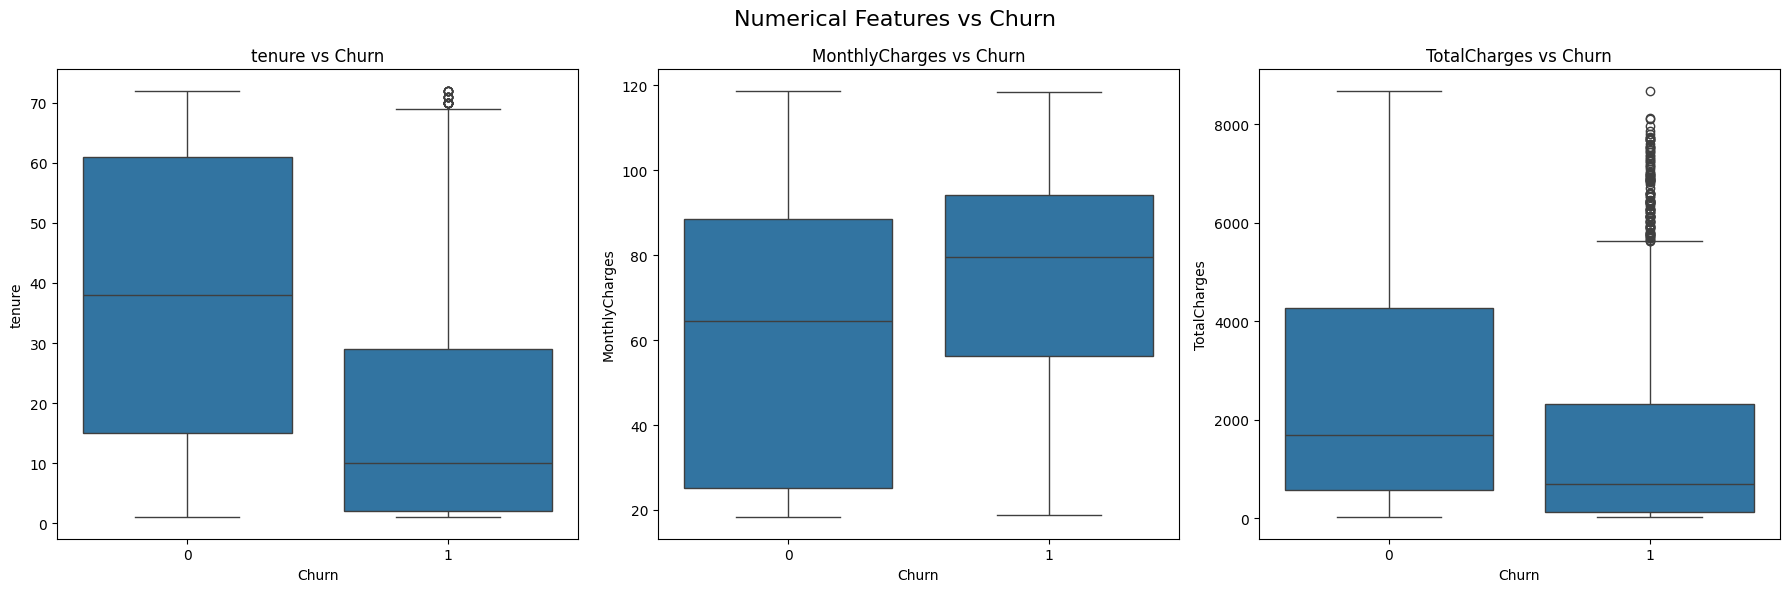

In [24]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Numerical Features vs Churn', fontsize=16)

for i, feature in enumerate(numerical_features):
    sns.boxplot(x='Churn', y=feature, data=data, ax=axes[i])
    axes[i].set_title(f'{feature} vs Churn')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

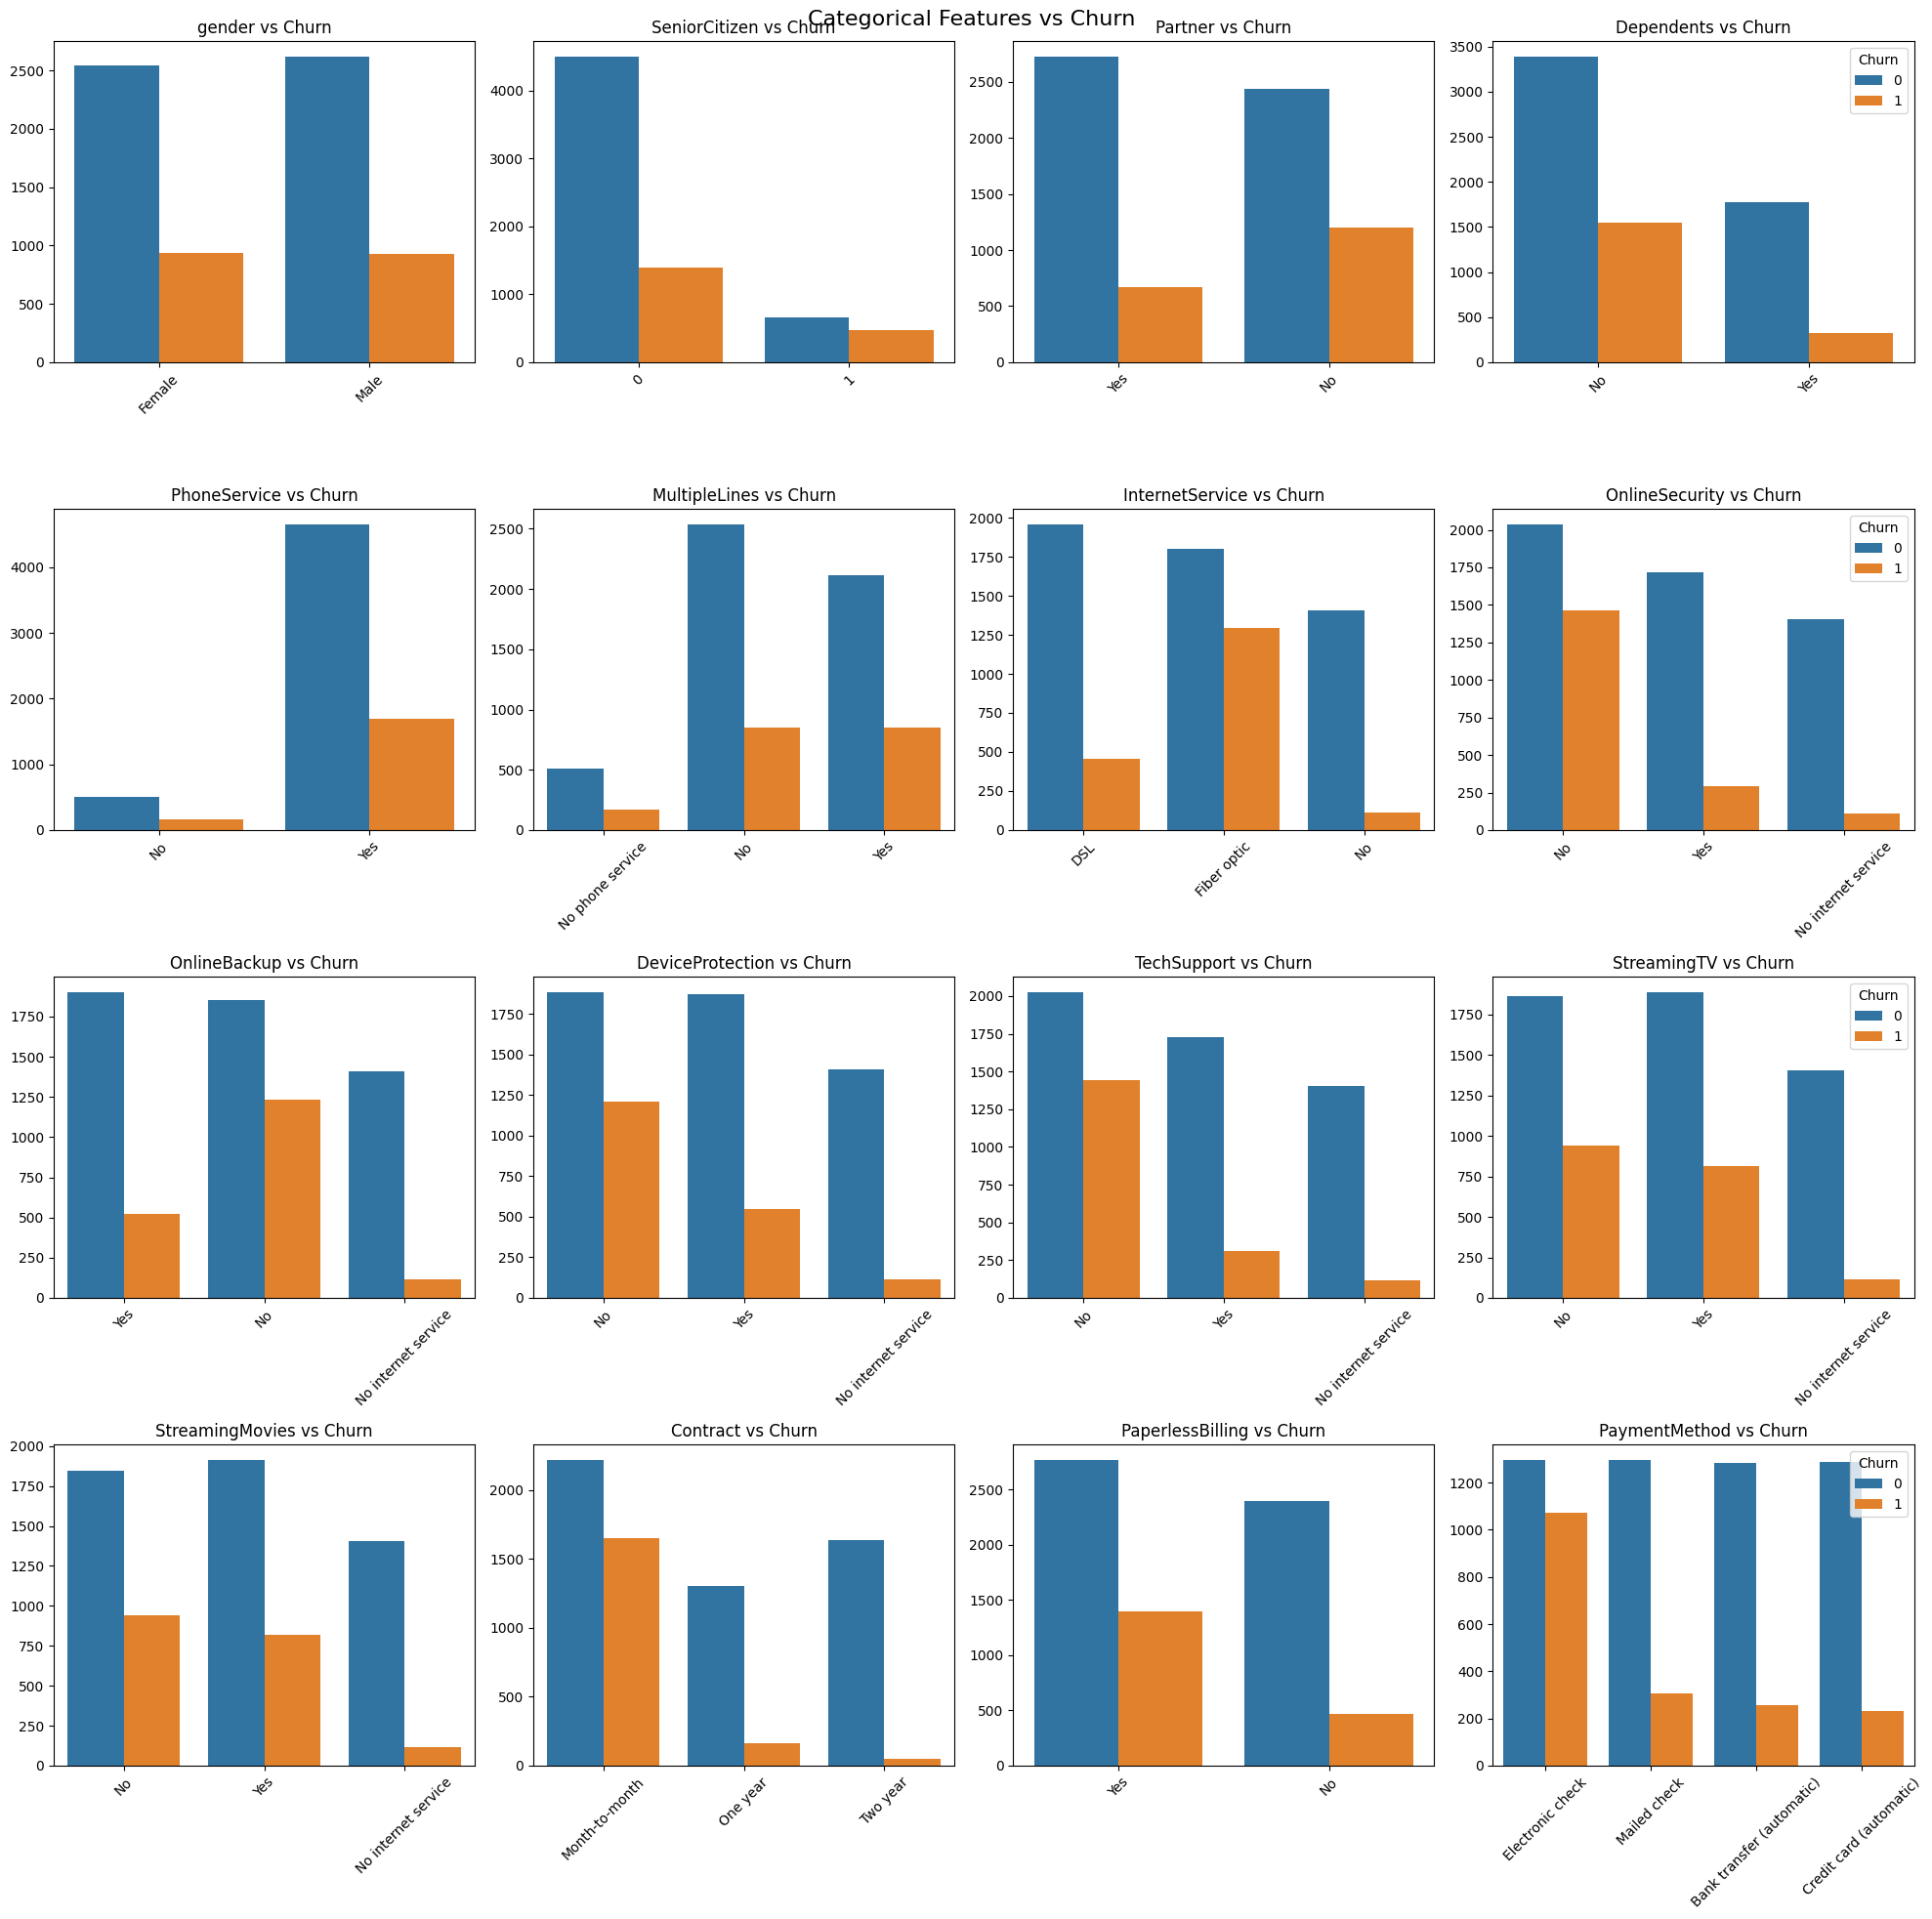

In [23]:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                        'PhoneService', 'MultipleLines', 'InternetService',
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                        'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

# Calculate the number of rows needed (4 plots per row)
n_rows = (len(categorical_features) + 3) // 4

fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5*n_rows))
fig.suptitle('Categorical Features vs Churn', fontsize=16)

for i, feature in enumerate(categorical_features):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    sns.countplot(x=feature, hue='Churn', data=data, ax=ax)
    ax.set_title(f'{feature} vs Churn')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)
    
    # Remove y-axis label to save space
    ax.set_ylabel('')
    
    # Only show legend for the rightmost plots
    if col != 3:
        ax.get_legend().remove()

# Remove any unused subplots
for i in range(len(categorical_features), n_rows * 4):
    row = i // 4
    col = i % 4
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

### 2.4 Feature Engineering

In [25]:
# Drop original 'Churn' column as we have 'Churn_numeric'
data_model = data.drop(['Churn'], axis=1)

# One-hot encoding for categorical variables
data_model = pd.get_dummies(data_model, drop_first=True)

# Display the first few rows of the processed data
data_model.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-MHZWF,customerID_0013-SMEOE,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


### 2.5 Feature Scaling

In [30]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Select numerical features for scaling
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Apply scaler
data_model[num_features] = scaler.fit_transform(data_model[num_features])

# Display scaled features
data_model.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,customerID_0003-MKNFE,customerID_0004-TLHLJ,customerID_0011-IGKFF,customerID_0013-EXCHZ,customerID_0013-MHZWF,customerID_0013-SMEOE,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.280248,-1.161694,-0.994194,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,0,0.064303,-0.260878,-0.173740,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
2,0,-1.239504,-0.363923,-0.959649,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
3,0,0.512486,-0.747850,-0.195248,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,0,-1.239504,0.196178,-0.940457,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False


## 3. Assumptions for Models
Before building models, we check if the assumptions for each model type (Linear, Logistic, and GAM) hold true.

### 3.1 Assumptions for Linear Regression

Linear regression assumes a linear relationship between the independent variables and the target. We check for linearity and multicollinearity.

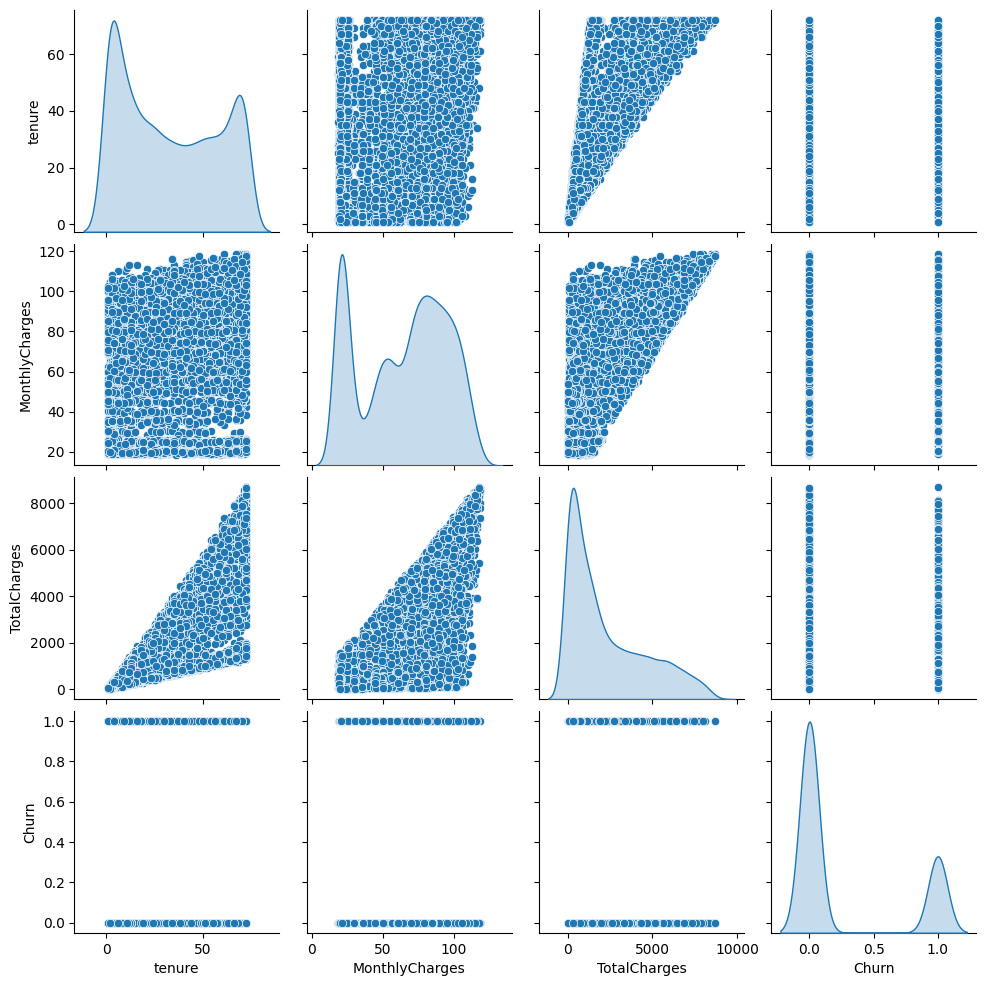

,feature,VIF
0,tenure,6.332432
1,MonthlyCharges,3.361075
2,TotalCharges,8.079181


In [26]:
# Pairplot to check for linearity
sns.pairplot(data[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], diag_kind='kde')
plt.show()

# VIF for multicollinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = data[['tenure', 'MonthlyCharges', 'TotalCharges']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data


### 3.2 Assumptions for Logistic Regression
Logistic regression assumes that the log-odds of the dependent variable is a linear combination of the independent variables. We check this assumption with visualizations.

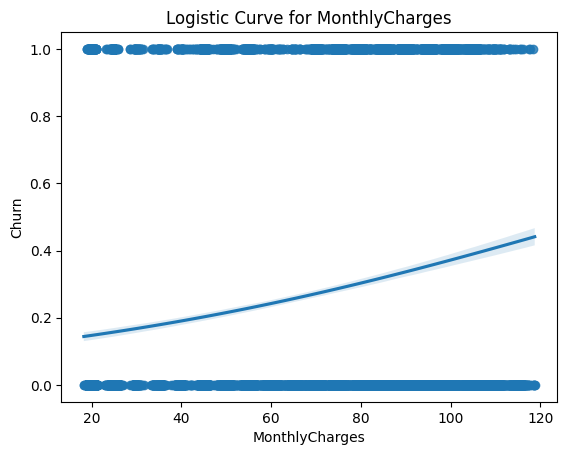

In [27]:
# Logistic curve for one of the numeric variables
sns.regplot(x='MonthlyCharges', y='Churn', data=data, logistic=True)
plt.title('Logistic Curve for MonthlyCharges')
plt.show()

### 3.3 Assumptions for GAM
GAM can handle non-linear relationships. We will explore non-linearity by plotting the relationship between numeric features and churn.

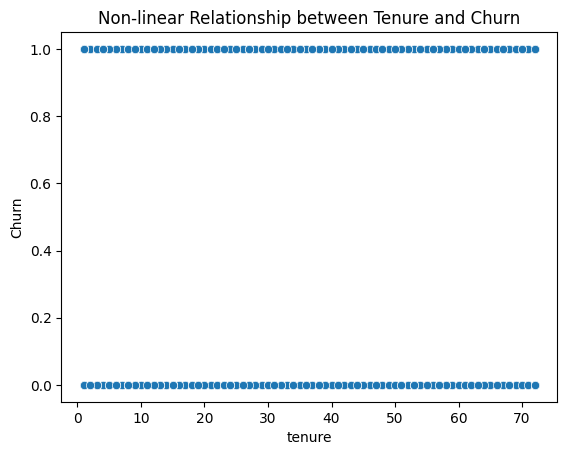

In [28]:
# Non-linear relationship check for GAM
sns.scatterplot(x='tenure', y='Churn', data=data)
plt.title('Non-linear Relationship between Tenure and Churn')
plt.show()

## 4. Linear Regression

### 4.1 Model Building
We treat churn as a continuous variable and build a linear regression model.

In [29]:
# Define features and target
X = data[['tenure', 'MonthlyCharges', 'TotalCharges']]
y = data['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Coefficients interpretation
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': linear_model.coef_})
coefficients


,Feature,Coefficient
0,tenure,-0.002658
1,MonthlyCharges,0.007261
2,TotalCharges,-0.000078


### 4.2 Residual Analysis for Linear Regression

Reason: Residual analysis checks whether the errors are randomly distributed. A non-random pattern indicates that the model does not capture all trends in the data.

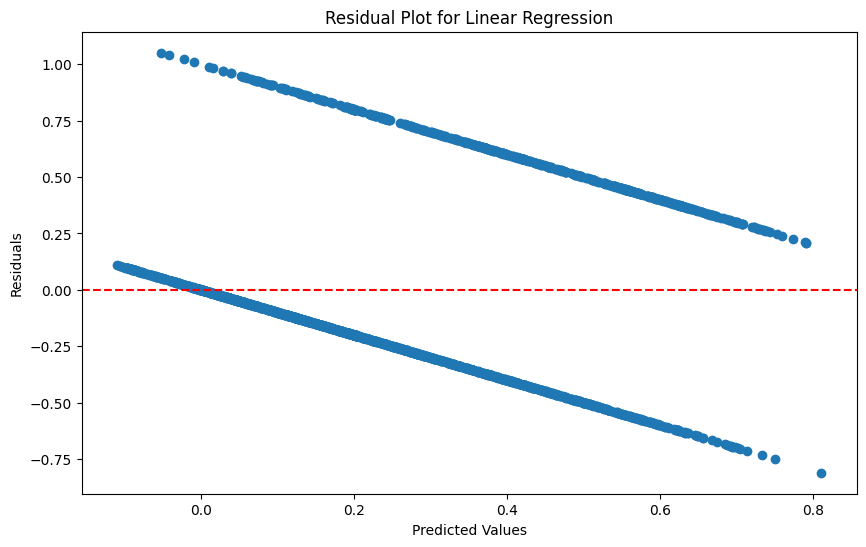

In [11]:
# Predicting on the test set
y_pred = linear_model.predict(X_test)

# Residuals
residuals = y_test - y_pred

# Plotting residuals
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


### 4.3 Model Evaluation
We evaluate the model using mean squared error (MSE) and R-squared.

In [12]:
# Predictions and evaluation
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = linear_model.score(X_test, y_test)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 0.15475092221279654
R-squared: 0.20716305869971707


## 5. Logistic Regression

### 5.1 Model Building

We now treat churn as a binary variable and build a logistic regression model.

In [13]:
# Fit logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Coefficients interpretation
logistic_coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': logistic_model.coef_[0]})
logistic_coefficients


,Feature,Coefficient
0,tenure,-0.069502
1,MonthlyCharges,0.030939
2,TotalCharges,0.000163


### 5.2 Model Evaluation

We use accuracy, ROC-AUC score to evaluate the logistic regression model.

In [14]:
# Predictions and evaluation
y_pred_log = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_log)
roc_auc = roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy}')
print(f'ROC-AUC: {roc_auc}')


Accuracy: 0.7748815165876777
ROC-AUC: 0.7995584524084884


## 6. Generalized Additive Model (GAM)

### 6.1 Model Building

Reason: We build a Generalized Additive Model (GAM) to capture potential non-linear relationships between customer features and churn. GAMs allow us to model each feature's effect on the target variable separately and additively, using smoothing functions. In this case, we'll focus on a logistic GAM since the target variable is binary (Churn: 0 or 1).

In [15]:
from pygam import LinearGAM, s, f
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Build the Generalized Additive Model (GAM) with linear terms
gam = LinearGAM(s(0) + s(1) + s(2))  # s() indicates smooth terms for the features

# Fit the model to the training data
gam.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gam.predict(X_test)



### 6.2 Model Evaluation

We evaluate the GAM model and interpret non-linear relationships.

In [16]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')


Mean Squared Error (MSE): 0.14721890509975022
R-squared (R²): 0.245751917004015


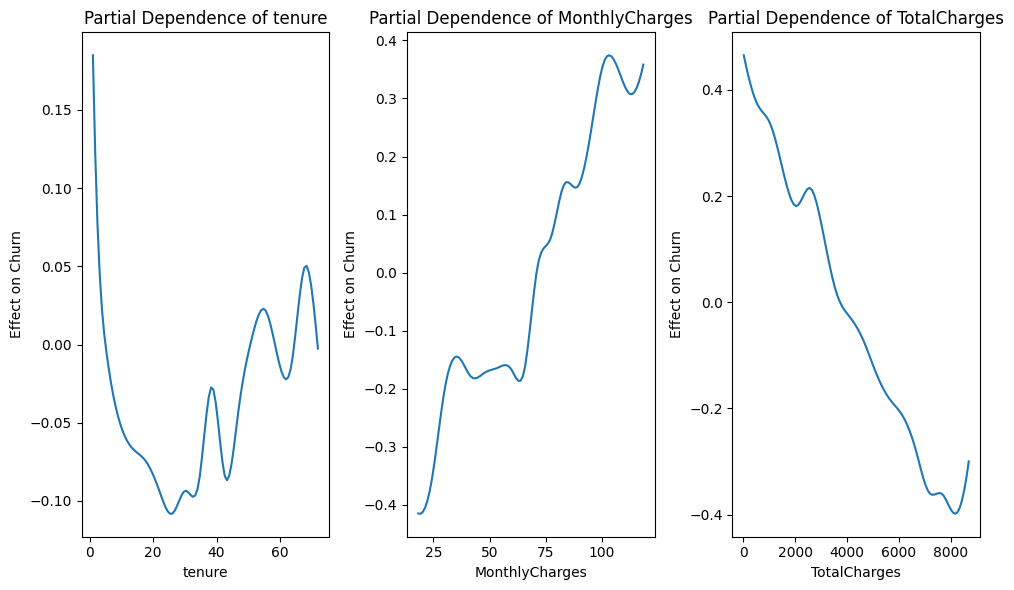

In [17]:
# Plot the model's partial dependence plots (PDP) for each feature
plt.figure(figsize=(10, 6))
for i, feature in enumerate(['tenure', 'MonthlyCharges', 'TotalCharges']):
    plt.subplot(1, 3, i+1)
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.title(f'Partial Dependence of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Effect on Churn')
plt.tight_layout()
plt.show()

# 7. Model Comparison
We compare the models (Linear, Logistic, and GAM) on both interpretability and performance.

In [18]:
# # Install SHAP if not already installed
# # !pip install shap

# import shap

# # Initialize the SHAP explainer
# explainer = shap.GammaExplainer(gam, X_train)

# # Calculate SHAP values for the test set
# shap_values = explainer.shap_values(X_test)

# # Plot summary plot
# shap.summary_plot(shap_values, X_test, plot_type='bar')


| Model               | MSE      | R-squared | Accuracy | ROC-AUC |
|---------------------|----------|-----------|----------|---------|
| Linear Regression    | X.XX     | X.XX      | N/A      | N/A     |
| Logistic Regression  | N/A      | N/A       | X.XX     | X.XX    |
| GAM                 | X.XX     | X.XX      | N/A      | N/A     |


In [19]:
# # Example new customer data
# new_customer = pd.DataFrame({
#     'tenure': [12],
#     'MonthlyCharges': [70]
# })

# # Predict probability of churn
# churn_probability = gam.predict_proba(new_customer)

# print(f'Predicted probability of churn: {churn_probability[0]:.4f}')


## 7. Advanced Model Interpretability

### 6.1 SHAP (SHapley Additive exPlanations) for Model Interpretation

Reason: SHAP values help in understanding the impact of each feature on the model's predictions by attributing the prediction of an individual instance to feature contributions.

/opt/anaconda3/envs/tourguideenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


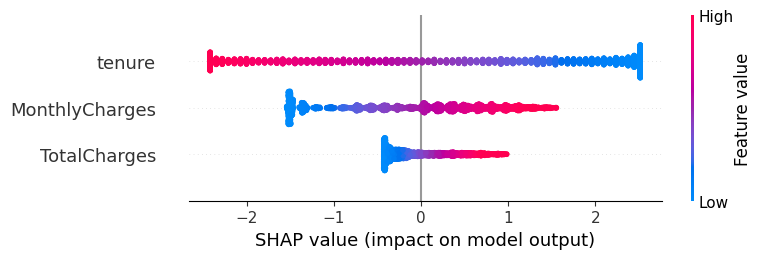

In [20]:
import shap

# SHAP values for logistic regression
explainer = shap.LinearExplainer(logistic_model, X_train)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)


### 6.2 LIME (Local Interpretable Model-agnostic Explanations)

Reason: LIME helps in explaining individual predictions by approximating the model locally with an interpretable model.

In [21]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize LIME explainer
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['Not Churn', 'Churn'], mode='classification')

# Explain a single prediction
i = 25  # Example index
exp = explainer.explain_instance(X_test.values[i], logistic_model.predict_proba)
exp.show_in_notebook(show_all=False)


/opt/anaconda3/envs/tourguideenv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


### 6.3 Partial Dependence Plots (PDP)

Reason: PDPs show the marginal effect of a feature on the predicted outcome, which helps in understanding the feature's global impact on predictions.

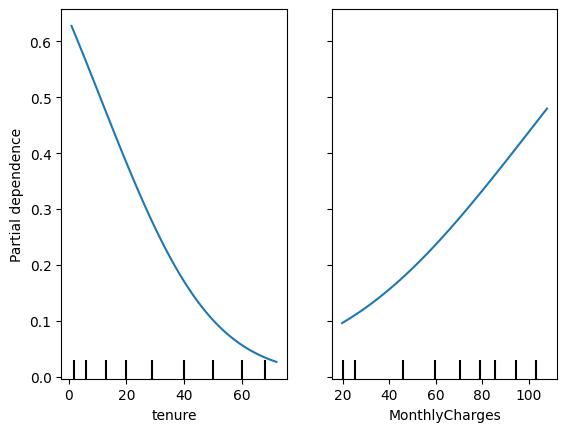

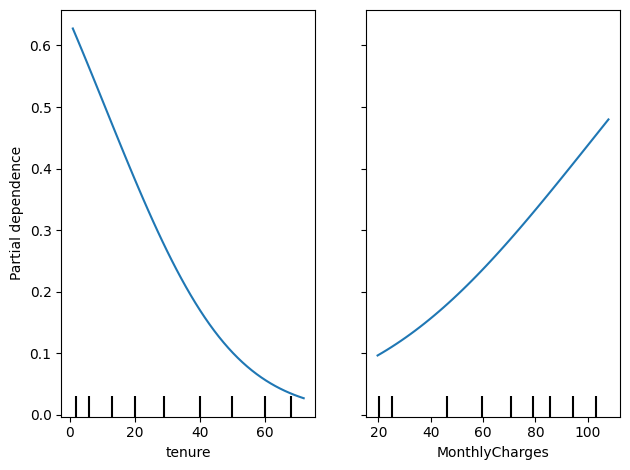

In [22]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Partial dependence plot for Logistic Regression
features = ['tenure', 'MonthlyCharges']
display = PartialDependenceDisplay.from_estimator(
    logistic_model, X_test, features, kind="average", grid_resolution=50
)
display.plot()
plt.tight_layout()
plt.show()

## References

- Kaggle Dataset: [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code)
- SHAP Documentation: https://shap.readthedocs.io/en/latest/
- LIME Documentation: https://lime-ml.readthedocs.io/en/latest/
- scikit-learn Documentation: https://scikit-learn.org/stable/documentation.html
- PyGAM Documentation: https://pygam.readthedocs.io/en/latest/


In [31]:
# comparison
# coefficients plot